In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# --- 設定 ---
# 建立儲存圖片的資料夾
SAVE_DIR = "tsne_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

def visualize_dataset(name):
    print(f"Processing {name}...")
    
    # 1. 加載數據 (NormalizeFeatures 對 t-SNE 效果比較好)
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=T.NormalizeFeatures())
    data = dataset[0]
    
    X = data.x.numpy()
    y = data.y.numpy()
    
    # 2. 執行 t-SNE
    # init='pca' 可以讓結果更穩定，n_jobs=-1 用盡 server 所有 CPU
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', n_jobs=10)
    X_embedded = tsne.fit_transform(X)
    
    # 3. 畫圖 (Layout 優化)
    plt.figure(figsize=(10, 10), dpi=300) # 高解析度
    
    # 繪製散點
    # alpha=0.6 增加透明度以觀察重疊，s=10 設定點的大小
    # cmap='tab10' 提供清晰的分類顏色
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', s=14, alpha=0.8)
    
    # 4. Layout 清潔化 (Remove clutter)
    # 移除座標軸與邊框 (因為 t-SNE 的座標數值無物理意義)
    plt.axis('off')
    
    # 加上標題與圖例
    plt.title(f"{name} (t-SNE)", fontsize=16, fontweight='bold', pad=20)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right", frameon=True, framealpha=0.9)
    
    # 5. 存檔
    save_path = os.path.join(SAVE_DIR, f"{name}_tsne.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close() # 關閉圖形以釋放記憶體
    
    print(f"  -> Saved to {save_path}")

# --- 執行 ---
datasets = ['Cora', 'CiteSeer', 'PubMed']

for name in datasets:
    visualize_dataset(name)

print("\nDone. Check the 'tsne_plots' folder.")

Processing Cora...
  -> Saved to tsne_plots/Cora_tsne.png
Processing CiteSeer...
  -> Saved to tsne_plots/CiteSeer_tsne.png
Processing PubMed...
  -> Saved to tsne_plots/PubMed_tsne.png

Done. Check the 'tsne_plots' folder.


Analyzing Cora...


/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


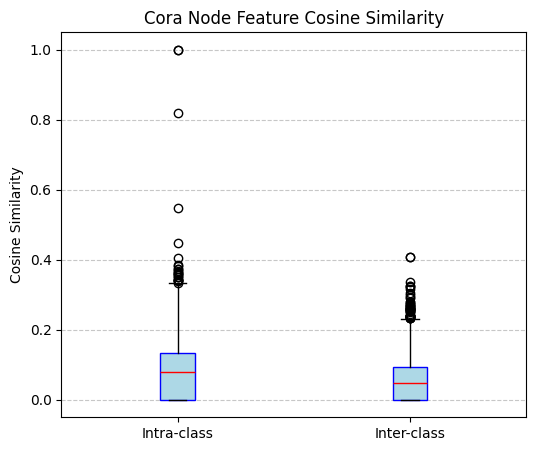

  -> Avg Intra-class Similarity: 0.0840
  -> Avg Inter-class Similarity: 0.0544
------------------------------
Analyzing CiteSeer...


Processing...
Processing...
Done!
Done!
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


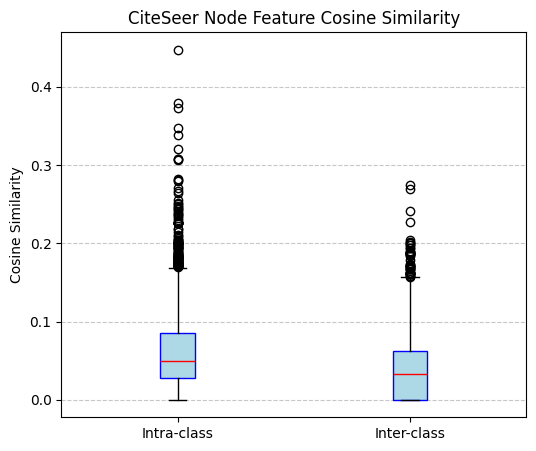

  -> Avg Intra-class Similarity: 0.0568
  -> Avg Inter-class Similarity: 0.0404
------------------------------
Analyzing PubMed...


Processing...
Processing...
Done!
Done!
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,
/tmp/ipykernel_1346773/1829397440.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([intra_sims, inter_sims], labels=['Intra-class', 'Inter-class'], patch_artist=True,


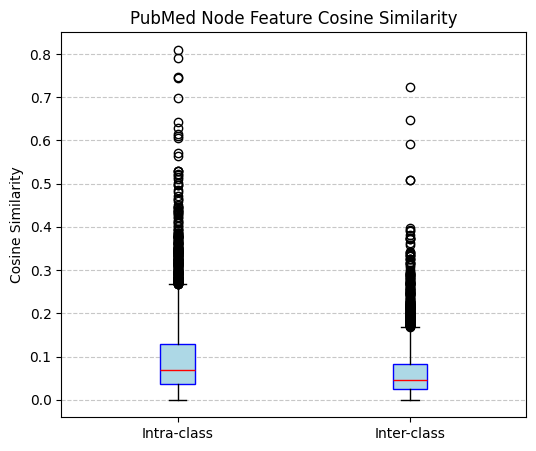

  -> Avg Intra-class Similarity: 0.0946
  -> Avg Inter-class Similarity: 0.0613
------------------------------


In [ ]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import numpy as np

def analyze_class_feature_similarity(name):
    print(f"Analyzing {name}...")
    # 1. 加載數據
    dataset = Planetoid(root=f'./data/{name}', name=name, transform=T.NormalizeFeatures())
    data = dataset[0]
    x = data.x
    y = data.y
    
    # L2 Normalize features so that dot product == cosine similarity
    # NormalizeFeatures 做的是 L1 norm (sum=1)，計算 Cosine Similarity 需要 L2 norm
    x = torch.nn.functional.normalize(x, p=2, dim=1)
    
    classes = torch.unique(y).numpy()
    class_sims_mean = []
    class_sims_std = []
    
    print(f"  Computing pairwise similarities for {len(classes)} classes...")
    
    for c in classes:
        # 提取該類別的所有節點特徵
        mask = (y == torch.tensor(c))
        x_c = x[mask]
        
        if x_c.size(0) < 2:
            class_sims_mean.append(0)
            class_sims_std.append(0)
            continue
            
        # 計算兩兩相似度矩陣 (N_c x N_c)
        # 因為已經做了 L2 normalization，矩陣乘法即為 Cosine Similarity
        sim_matrix = torch.mm(x_c, x_c.t())
        
        # 取上三角矩陣 (不包含對角線)，即所有不重複的兩兩配對
        rows, cols = torch.triu_indices(x_c.size(0), x_c.size(0), offset=1)
        
        if len(rows) > 0:
            sims = sim_matrix[rows, cols]
            class_sims_mean.append(sims.mean().item())
            class_sims_std.append(sims.std().item())
        else:
            class_sims_mean.append(0)
            class_sims_std.append(0)

    # 4. 畫圖 (Bar Chart)
    plt.figure(figsize=(10, 6))
    
    # 繪製柱狀圖
    x_pos = np.arange(len(classes))
    # yerr 顯示標準差，觀察分佈的離散程度
    bars = plt.bar(x_pos, class_sims_mean, yerr=class_sims_std, align='center', alpha=0.7, ecolor='black', capsize=10, color='skyblue')
    
    plt.xlabel('Class ID')
    plt.ylabel('Average Cosine Similarity')
    plt.title(f'{name} Intra-class Feature Cosine Similarity')
    plt.xticks(x_pos, classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.0) # Cosine similarity range [0, 1] usually for non-negative features
    
    # 在柱狀圖上方標示數值
    for bar, v in zip(bars, class_sims_mean):
        plt.text(bar.get_x() + bar.get_width() / 2, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
        
    plt.show()
    
    print(f"  -> Class Means: {['{:.3f}'.format(x) for x in class_sims_mean]}")
    print("-" * 30)

# --- 執行 ---
datasets = ['Cora', 'CiteSeer', 'PubMed']
for name in datasets:
    analyze_class_feature_similarity(name)

In [2]:
import torch
from torch_geometric.datasets import Reddit
from ogb.nodeproppred import PygNodePropPredDataset
import numpy as np
from torch_geometric.utils import degree
import torch_geometric.transforms as T

def analyze_graph_statistics(name, dataset):
    print(f"Analyzing {name}...")
    data = dataset[0]
    
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_features
    
    # Handle classes
    if hasattr(data, 'y') and data.y is not None:
        # Check for NaN values in y (common in OGB)
        y_clean = data.y[~torch.isnan(data.y)]
        if data.y.dim() > 1 and data.y.shape[1] > 1:
             # Multi-label
             num_classes = data.y.shape[1]
        else:
             num_classes = len(torch.unique(y_clean))
    else:
        num_classes = "N/A"

    # Check directionality
    is_undirected = data.is_undirected()
    
    # Calculate degrees
    # degree() computes in-degree if using edge_index[1] or out-degree if edge_index[0]
    # For undirected graphs represented with bidirectional edges, this gives the degree.
    d = degree(data.edge_index[0], num_nodes=num_nodes)
    avg_degree = d.mean().item()
    max_degree = d.max().item()
    min_degree = d.min().item()
    
    # Density: E / (N * (N-1)) for directed, 2E / (N * (N-1)) for undirected (if E is unique pairs)
    # Since PyG stores undirected as 2 directed edges, num_edges is 2*|E|.
    # So density = num_edges / (N * (N-1)) works for both cases roughly.
    density = num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    print(f"  Nodes: {num_nodes:,}")
    print(f"  Edges: {num_edges:,}")
    print(f"  Features: {num_features}")
    print(f"  Classes: {num_classes}")
    print(f"  Is Undirected: {is_undirected}")
    print(f"  Average Degree: {avg_degree:.4f}")
    print(f"  Max Degree: {max_degree:.4f}")
    print(f"  Min Degree: {min_degree:.4f}")
    print(f"  Density: {density:.6f}")
    print("-" * 30)

# Ogbn-arxiv
# Arxiv is a directed citation graph.
try:
    print("Loading ogbn-arxiv...")
    dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/ogbn-arxiv')
    # To analyze it as an undirected graph (co-citation/collaboration style view), we can transform it, 
    # but usually we analyze the raw graph first.
    analyze_graph_statistics('ogbn-arxiv', dataset_arxiv)
except Exception as e:
    print(f"Error loading ogbn-arxiv: {e}")

# Reddit
try:
    print("Loading Reddit...")
    dataset_reddit = Reddit(root='./data/Reddit')
    analyze_graph_statistics('Reddit', dataset_reddit)
except Exception as e:
    print(f"Error loading Reddit: {e}")

Loading ogbn-arxiv...
Analyzing ogbn-arxiv...
  Nodes: 169,343
  Edges: 1,166,243
  Features: 128
  Classes: 40
  Is Undirected: False
  Average Degree: 6.8869
  Max Degree: 436.0000
  Min Degree: 0.0000
  Density: 0.000041
------------------------------
Loading Reddit...
Analyzing Reddit...
Analyzing Reddit...
  Nodes: 232,965
  Edges: 114,615,892
  Features: 602
  Classes: 41
  Is Undirected: True
  Average Degree: 491.9876
  Max Degree: 21657.0000
  Min Degree: 1.0000
  Density: 0.002112
------------------------------
  Nodes: 232,965
  Edges: 114,615,892
  Features: 602
  Classes: 41
  Is Undirected: True
  Average Degree: 491.9876
  Max Degree: 21657.0000
  Min Degree: 1.0000
  Density: 0.002112
------------------------------
